# Navigation

---

In this notebook we will use Deep Q-Learning to train an agent for Banana Collector environment. This environment is similar, but not indentical to Banana Collector environment of [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt

Import agents

In [2]:
import sys
sys.path.append('./code')
from random_agent import RandomAgent
from dqn_agent import DQNAgent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [3]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

The cells below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, we will show how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, we will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

In [6]:
def run_agent(agent, train=False, max_steps=1000, verbose=True, epsilon=0.1):
    env_info = env.reset(train_mode=train)[brain_name]
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    step_counter = 0                                   # initialize step counter
    
    while step_counter < max_steps:
        action = agent.act(state, epsilon)                 # get next action from the agent 
        env_info = env.step(int(action))[brain_name]   # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        if train:
            agent.step(state, action, reward, next_state, done)
        state = next_state                             # roll over the state to next time step
        step_counter += 1                              # update step counter
        
        if done:                                       # exit loop if episode finished
            break
        
    if verbose:    
        print("Score: {}".format(score))
        print("Number of steps: {}".format(step_counter))
    
    return score

In [7]:
agent = RandomAgent(action_size=action_size, seed=0)
run_agent(agent)

Score: 0.0
Number of steps: 300


0.0

### 4. Run untrained agent 

In the next code cells we will run untrained agent. Since the agent is untrained, its performance should be similar to the one of the agent that selects random actions. 

In [8]:
agent = DQNAgent(state_size=state_size, action_size=action_size, seed=0)
run_agent(agent)

Score: -1.0
Number of steps: 300


-1.0

### 5. Train an agent

In [9]:
def train_dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):  
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        score = run_agent(agent, train=True, max_steps=max_t, verbose=False, epsilon=eps)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [10]:
scores = train_dqn(agent)

C:\Miniconda3\envs\drlnd\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Episode 100	Average Score: 1.11
Episode 200	Average Score: 3.93
Episode 300	Average Score: 8.17
Episode 400	Average Score: 9.79
Episode 500	Average Score: 12.56
Episode 553	Average Score: 13.00
Environment solved in 453 episodes!	Average Score: 13.00


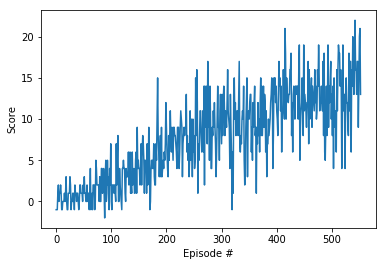

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Run trained agent

In [18]:
trained_agent = DQNAgent(state_size=state_size, action_size=action_size, seed=0, file_name='checkpoint.pth')
run_agent(trained_agent)

Score: 20.0
Number of steps: 300


20.0

### 7. Close environment

In [ ]:
env.close()